In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lasio
import os
import glob
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from fastdtw import fastdtw
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import networkx as nx
import scipy.interpolate
import time


In [5]:
# directory on personal computer
ruta = os.getcwd()+"/Datos"
#os.chdir(ruta)

ruta_logs = ruta + "/Datos VH_III"
ruta_archivo = ruta_logs +"/Datos VH_III.xlsx"
markers_file = ruta_logs + "/Markers VH3.xlsx"

las_files = glob.glob(os.path.join(ruta_logs, '*.las'))
log_files = glob.glob(os.path.join(ruta_logs, '*.log'))


# Create a directed graph
G = nx.DiGraph()

# get data from excel
well_data = pd.read_excel(ruta_archivo)
markers = pd.read_excel(markers_file)

def las_to_node(G, filename, col_name):
    node_name = os.path.splitext(os.path.basename(filename))[0]
    las = lasio.read(filename)
    las_df = las.df().dropna()
    las_df = las_df.reset_index()
    new_las = pd.DataFrame(columns=["DEPTH",'RES_DEEP'])
    new_las["DEPTH"] = las_df["DEPTH"]
    new_las["RES_DEEP"] = las_df[col_name]

    coord_data = well_data[well_data["Nombre"]==node_name]
    x_coord = coord_data.iloc[0, 5]
    y_coord = coord_data.iloc[0, 6]

    G.add_node(node_name, data=new_las, pos=(x_coord, y_coord))

    # Add tops
    tops_data = pd.read_excel(ruta_archivo, sheet_name=node_name)
    tops_data = tops_data.drop(index=0)

    a = tops_data[["Capa", "Top"]].copy()
    a.rename(columns={"Top": "Ref"}, inplace=True)

    

    b=tops_data[["Capa", "Base"]].copy()
    b.rename(columns={"Base": "Ref"}, inplace=True)
    resultado = pd.concat([a, b], ignore_index=True)

    tops_vals = resultado.sort_values(by='Ref', ascending=True).reset_index().dropna()

    # print(f"Resultados {node_name}")
    # print(resultado.head(5))
    # print()


    G.nodes[node_name]["markers"] = markers[markers["Pozo"]==node_name]

    G.nodes[node_name]["known_tops"]=tops_vals.copy()

# TODO finish this, .log files currently do not work
def log_to_node(G, filename, col_name):
    log_data = []
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    # Identify header and determine the indices of the columns of interest
    header = lines[0].strip().split()
    depth_idx = header.index("DEPTH")
    col_idx = header.index(col_name)

    new_log = pd.DataFrame(columns=["DEPTH",'RES_DEEP'])

    new_log["DEPTH"] = lines[depth_idx]
    new_log["RES_DEEP"] = lines[col_idx]

    print(lines[2])


las_to_node(G, las_files[0], "HT90")
las_to_node(G, las_files[1], "HT90")
las_to_node(G, las_files[2], "HDRS")

#log_to_node(G, log_files[0], "M2R9")
ruta_logs = ruta + "/Perfiles_3"
las_files = glob.glob(os.path.join(ruta_logs, '*.las'))

las_to_node(G, las_files[0], "RES_DEEP")
las_to_node(G, las_files[1], "RES_DEEP")
las_to_node(G, las_files[2], "RES_DEEP")


def load_markers(G, node_name):
    G.nodes[node_name]["markers"] = markers[markers["Pozo"]==node_name]



Un grafo ciclico con 3 nodos, esto podria cambiar en el futuro

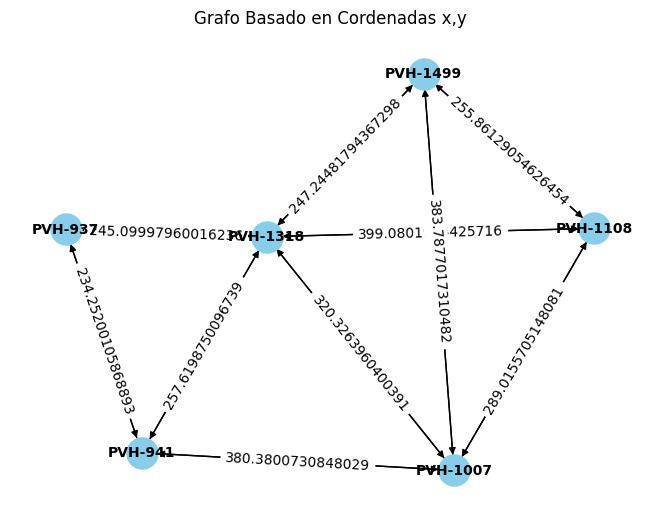

In [6]:
#%%
# Function to calculate geodesic distance between two points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

def euclidian_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

threshold_distance = 400  # Define a distance threshold

for node1, data1 in G.nodes(data=True):
    for node2, data2 in G.nodes(data=True):
        if node1 != node2:
            pos1 = data1['pos']
            pos2 = data2['pos']
            distance = euclidian_distance(pos1[0], pos1[1], pos2[0], pos2[1])
            if distance <= threshold_distance:
                G.add_edge(node1, node2, weight=distance)

# Visualize the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title("Grafo Basado en Cordenadas x,y")
plt.show()

In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
pd.set_option('display.max_rows', None)

# helper methods
def normalize_array(arr):
    reshaped_arr = arr.reshape(-1, 1)
    scaler = MinMaxScaler()
    normalized_arr = scaler.fit_transform(reshaped_arr)
    return normalized_arr

def custom_distance(p1, p2):
    return np.abs(p1 - p2) **(1/ 4.3)



# node 1 is the curernt node
# node 2 is the node you attempt to move to
# function gets a dataframe with the predicted depths, assigns to "tops" label in node
# window in the format [start1, end1, start2, end2]
def calc_tops(G, node1, node2, window = None, show_comparison = False):

    # create a new dataframe that takes the values of node2 where the "capa" value is the same as in node1
    
    df1 = G.nodes[node1]["data"].copy() # RES_DEEP data for node1
    tops1 = G.nodes[node1]["known_tops"].copy() # Tops data for node1
    df2 = G.nodes[node2]["data"].copy() # RES_DEEP data for node2

    capas = G.nodes[node1]["known_tops"]["Capa"]

    # TODO will need to fix this because it is assigning the wrong tops labels to depths
    if window:
        lower = np.min([window[0], window[2]])
        upper = np.max([window[1], window[3]])

        # verify correct window
        if len(window) != 4:
            print("invalid window")
            return
        
        start1 = window[0]
        end1 = window[1]
        start2 = window[2]
        end2 = window[3]

        # filter all the corresponding dataframes
        df1 = df1[(df1["DEPTH"]>=start1) & (df1["DEPTH"]<=end1)].copy()
        df2 = df2[(df2["DEPTH"]>=start2) & (df2["DEPTH"]<=end2)].copy()
        tops1 = tops1[(tops1["Ref"]>=start1) & (tops1["Ref"]<=end1)].reset_index(drop=True).copy()
        capas = tops1["Capa"].copy()
        
        if show_comparison:
            profiles_comparison(df1, df2, tops1, r=[lower, upper], name1=node1, name2=node2)

    df_result = predict(df1, df2, tops1)
    df_result["Capa"] = capas
    
    # assign new top values to the node
    G.nodes[node2]["tops"]=df_result

def verify(G, node_name, show_plots = False, window = None):
    if "tops" in G.nodes[node_name]:
        pred = G.nodes[node_name]["tops"].copy()
        known = G.nodes[node_name]["known_tops"].copy()

        if window:
            start1 = window[0]
            end1 = window[1]
            known = known[(known["Ref"]>=start1) & (known["Ref"]<=end1)]

        result = pd.DataFrame(columns=["Capa", "known depth", "predicted depth"])
        result["Capa"] = pred["Capa"]
        result["known depth"] = known["Ref"]
        result["predicted depth"] = pred["Ref"]
        result["abs error"] = np.abs(result['known depth'] - result['predicted depth'])

        print(result)

        if show_plots:
            
            plt.figure(figsize=(12, 6))
            plt.plot(result['predicted depth'], result['abs error'], label='Error Absoluto', color='purple')
            plt.xlabel('Depth (m)')
            plt.ylabel('Error Absoluto (m)')
            plt.title(f'Error Absoluto entre Predicción y Valores Verdaderos en {node_name}')
            plt.legend()
            plt.show()
            
            # capas side by side plot
            plt.figure(figsize=(12, 6))
            plt.scatter(result['predicted depth'], result['Capa'], color='blue', label='Predicción')
            plt.scatter(result['known depth'], result['Capa'], color='red', label='Verdadero')

            plt.xlabel('Depth (m)')
            plt.ylabel('Capa')
            plt.title(f'Evaluación de Capas {node_name}')
            plt.legend()
            plt.show()

    else:
        print("Prediction has not been run yet")

def dtw_calc(G, df1, df2, tops1):
    tolerance = 0.1 #original 0.05, was too small

    # mark rows within the tolerance range of any top
    
    for index_df1, row_df1 in df1.iterrows():
        depth_value = row_df1['DEPTH']
        matches = tops1['Ref'].apply(lambda x: np.abs(x - depth_value) <= tolerance)
        
        if matches.any():
            df1.loc[index_df1, 'Present'] = 1 # SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame. Try using .loc[row_indexer,col_indexer] = value instead
            matched_index = matches.idxmax()
            tops1 = tops1.drop(index=matched_index) # if a match is found, delete the top to avoid duplicate matches
            
            # If tops1 is empty, break the loop
            if tops1.empty:
                break
            

    G.nodes[node1]["is_top"] = df1[df1['Present'] == 1] # store the filtered rows near the caps into the graph
    prof1 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"][0] - 50
    prof2 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"].iloc[-1] + 50
    df1 = df1[(df1['DEPTH'] > prof1) & (df1['DEPTH'] < prof2)].reset_index()
    df2 = df2[(df2['DEPTH'] > prof1) & (df2['DEPTH'] < prof2)].reset_index()


    # normalize res deep in df1 and df2
    w1 = np.array(df1['RES_DEEP'].dropna())
    w2 = np.array(df2['RES_DEEP'].dropna())

    # use normalized values
    w1_normalized = normalize_array(w1)
    w2_normalized = normalize_array(w2)


    ref = df1[df1["Present"] == 1]
    distance, path = fastdtw(w1_normalized, w2_normalized, dist=custom_distance)
    correla = [tupla for tupla in path if tupla[0] in ref.index]

    return correla, df1, df2

def predict(df1, df2, tops1):
    correla, df1, df2 = dtw_calc(G, df1, df2, tops1)
    
    df_result = pd.DataFrame(columns=["Capa",'Ref'])

    # create a list of j values for unique i values
    j_values_dict = {}

    for i, j in correla:
        
        if i not in j_values_dict:
            j_values_dict[i] = []
        j_values_dict[i].append(j)

    rows_to_add = []
    # obtaining a 1 to 1 relationship between i and j by averaging 
    for i, j_values in j_values_dict.items():
        i_depth = df1["DEPTH"].iloc[i]
        j_depths = [df2["DEPTH"].iloc[j] for j in j_values]

        # averaging j values
        j_depth = np.mean(j_depths) # averaging, may want to try a different method later
        #print(f'i = {i_depth}, j = {j_depths}') #print the j values for each corresponding i value
        rows_to_add.append({'Ref': j_depth})

    
    
    df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True) # Future Warning

    return df_result

def profiles_comparison(df1, df2, tops1, r=None, vertical = False, name1 = None, name2 = None):

    correla, df1, df2 = dtw_calc(G, df1, df2, tops1)

    offset = 50
    plt.figure(figsize=(6, 10))

    # Plot df1
    plt.plot(df1["RES_DEEP"], df1["DEPTH"], label=name1, color='blue')

    # Plot df2 with offset
    plt.plot(df2["RES_DEEP"] + offset, df2["DEPTH"], label=name2, color='orange')


    for i, j in correla:
        # Plot the DTW path
        plt.plot([df1["RES_DEEP"].iloc[i], df2["RES_DEEP"].iloc[j] + offset], 
                 [df1["DEPTH"].iloc[i], df2["DEPTH"].iloc[j]], 
                 color='red', linestyle='-')
    if name1 is not None and name2 is not None:
        plt.title(f"Reference Node: {name1}, Prediction Node: {name2}")
    plt.xlabel('Valor')
    if r:
        plt.ylim(r[0], r[1])
    plt.ylabel('Depth')
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()

def raw_data(G, names, r=None):
    offset = 50
    colormap = plt.cm.viridis
    num_colors = len(names)
    colors = [colormap(i) for i in np.linspace(0, 1, num_colors)]

    plt.figure(figsize=(6, 10))
    index = 0
    for i, n in enumerate(names):
        df1 = G.nodes[n]["data"].copy()
        plt.plot(df1["RES_DEEP"] + offset*index, df1["DEPTH"], label=n, color=colors[i])
        index += 1

    plt.title(f"Raw Resistivity Data")
    plt.xlabel('Valor')

    if r:
        plt.ylim(r[0], r[1])
    plt.ylabel('Depth')
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()

def windows_test(G, node_name1, node_name2, window, show_plots = False):
    start1 = window[0]
    end1 = window[1]
    start2 = window[2]
    end2 = window[3]

    data1 = G.nodes[node_name1]["data"].copy()
    data2 = G.nodes[node_name2]["data"].copy()
    tops1 = G.nodes[node_name1]["known_tops"].copy()
    tops2 = G.nodes[node_name2]["known_tops"].copy() # this is only used to verify

    f_data1 = data1[(data1["DEPTH"]>=start1) & (data1["DEPTH"]<=end1)]
    f_data2 = data2[(data2["DEPTH"]>=start2) & (data2["DEPTH"]<=end2)]
    f_tops1 = tops1[(tops1["Ref"]>=start1) & (tops1["Ref"]<=end1)].reset_index()
    f_tops2 = tops2[(tops2["Ref"]>=start2) & (tops2["Ref"]<=end2)].reset_index() # make sure that resetting index didn't mess up the algoritm

    capas = f_tops1["Capa"]
    capas2 = f_tops2["Capa"]
    

    result = predict(f_data1, f_data2, f_tops1)
    result["Capa"] = capas

    # note: there may be errors at end condition if window cuts off a top or base, will need to handle in the future

    error_df = result[result["Capa"].isin(capas2)].reset_index() 
    error_df.rename(columns={'Ref': 'pred'}, inplace=True)

    real = f_tops2[f_tops2["Capa"].isin(capas)].reset_index(drop=True)
    
    error_df["real"] = real["Ref"]
    error_df["abs error"] = np.abs(error_df['pred'] - error_df['real'])

    mae = np.mean(error_df["abs error"])
    mse = np.mean((error_df['pred'] - error_df['real'])**2)

    if show_plots:
        
        profiles_comparison(f_data1, f_data2, f_tops1, name1=node_name1, name2=node_name2)

        # error plot
        plt.figure(figsize=(12, 6))
        plt.plot(error_df['pred'], error_df['abs error'], label='Error Absoluto', color='purple')
        plt.xlabel('Depth (m)')
        plt.ylabel('Error Absoluto (m)')
        plt.title(f'Error Absoluto entre Predicción y Valores Verdaderos en {node_name2} con rango {start2}m - {end2}m')
        plt.legend()
        plt.show()
        
        # capas side by side plot
        plt.figure(figsize=(12, 6))
        plt.scatter(error_df['pred'], error_df['Capa'], color='blue', label='Predicción')
        plt.scatter(error_df['real'], error_df['Capa'], color='red', label='Verdadero')

        plt.xlabel('Depth (m)')
        plt.ylabel('Capa')
        plt.title(f'Evaluación de Capas {node_name2} con rango {start2}m - {end2}m')
        plt.legend()
        plt.show()
    return mae, mse

def clear_tops(G, node_name):
    G.nodes[node_name]["tops"] = pd.DataFrame()



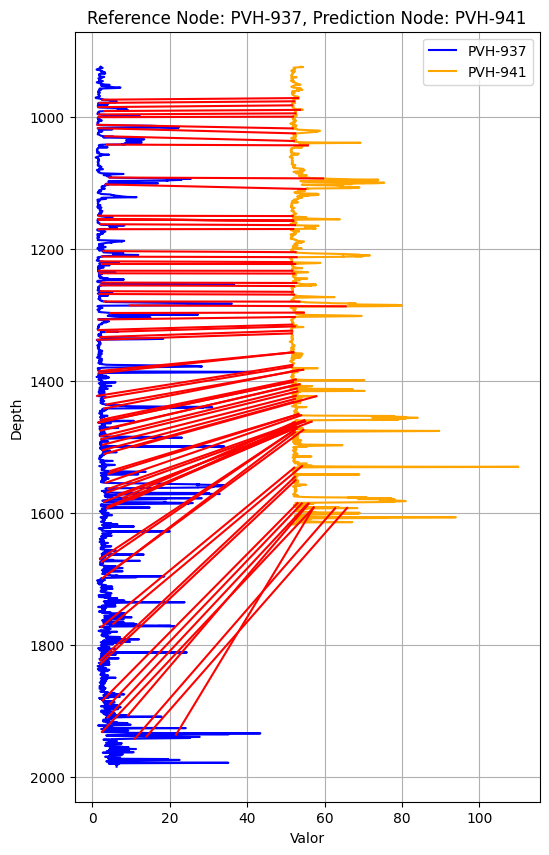

In [19]:
node_name1 = "PVH-937"
node_name2 = "PVH-941"

data1 = G.nodes[node_name1]["data"].copy()
data2 = G.nodes[node_name2]["data"].copy()
tops1 = G.nodes[node_name1]["known_tops"].copy()

profiles_comparison(data1, data2, tops1, name1=node_name1, name2=node_name2)

Now that everything works, I need to find the optimal windows so that windows_test returns minimal error, I think I will just be looking at mae right now

In [9]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import numpy as np
 

# optimization function to find the best window
def optimal_window(G, node_name1, node_name2, bounds, returnType = "mse", step_size = 0.5, num_iter = 50):    


    def objective(params):
        start1, end1, start2, end2 = params
        win = [start1, end1, start2, end2]
        if start1 >= end1 or start2 >= end2:
            return {'loss': float('inf'), 'status': STATUS_OK}  # Invalid window, return a large value

        mae, mse = windows_test(G, node_name1, node_name2, win)

        if returnType == "mse":
            return {'loss': mse, 'status': STATUS_OK}
        
        elif returnType == "mae":
            return {'loss': mae, 'status': STATUS_OK}
    

    # bounds
    space = [
        hp.quniform('start1', bounds[0][0], bounds[0][1], step_size),
        hp.quniform('end1', bounds[1][0], bounds[1][1], step_size),
        hp.quniform('start2', bounds[2][0], bounds[2][1], step_size),
        hp.quniform('end2', bounds[3][0], bounds[3][1], step_size)
    ]
 
    trials = Trials()
    
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=num_iter,
        trials=trials,
        rstate=np.random.default_rng(0)
    )
    
    optimal_windows = [best['start1'], best['end1'], best['start2'], best['end2']]
    min_err = min(trial['result']['loss'] for trial in trials)

    return optimal_windows, min_err
    


In [11]:
node_name1 = "PVH-937"
node_name2 = "PVH-941"
bounds = [(900, 1200), (1400, 2000), (900, 1200), (1400, 1700)]

optimal_window, error = optimal_window(G, node_name1, node_name2, bounds)

print(f"Optimal windows: {optimal_window}")
print(f"Minimum mse: {error}")


100%|██████████| 50/50 [01:00<00:00,  1.21s/trial, best loss: 12.440748148148199]
Optimal windows: [1152.0, 1505.0, 1156.5, 1541.0]
Minimum mse: 12.440748148148199


Now that we have found the optimal window, we can expand to the rest of the graph

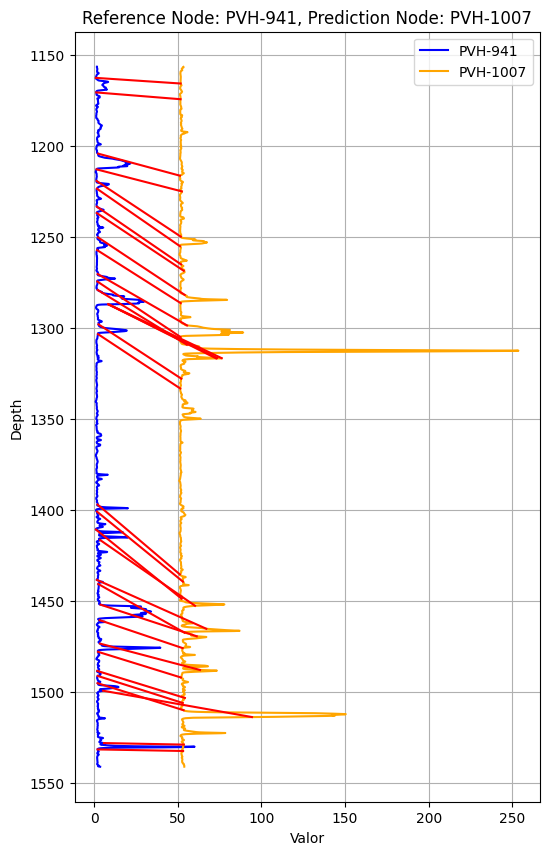

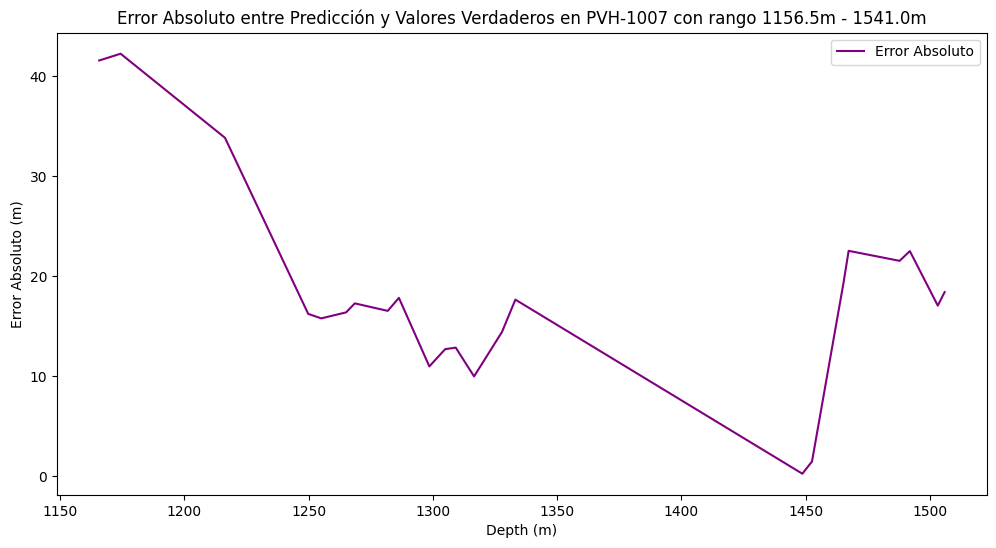

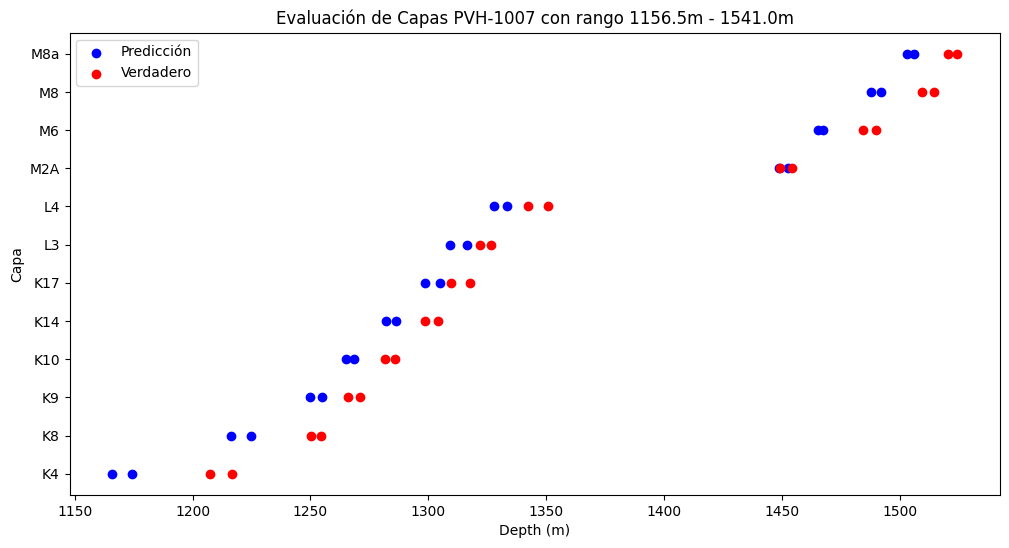

(18.71041666666676, 447.8694270833368)

In [14]:
start_node = node_name2
bound1 = optimal_window[2]
bound2 = optimal_window[3]
w = [bound1, bound2, bound1, bound2]

new_node = "PVH-1007"
calc_tops(G, start_node, new_node, window=w)
windows_test(G, start_node, new_node, w, show_plots=True)
#verify(G, new_node, show_plots=False)


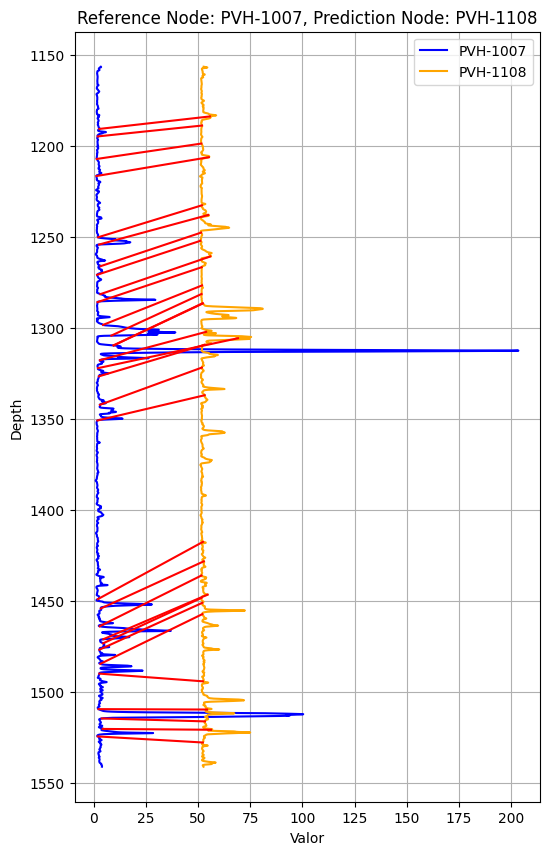

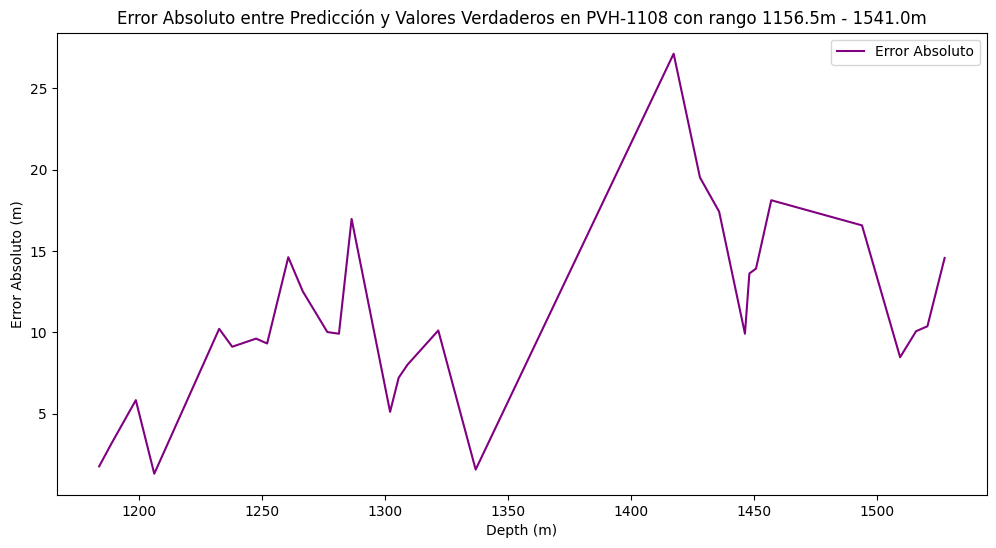

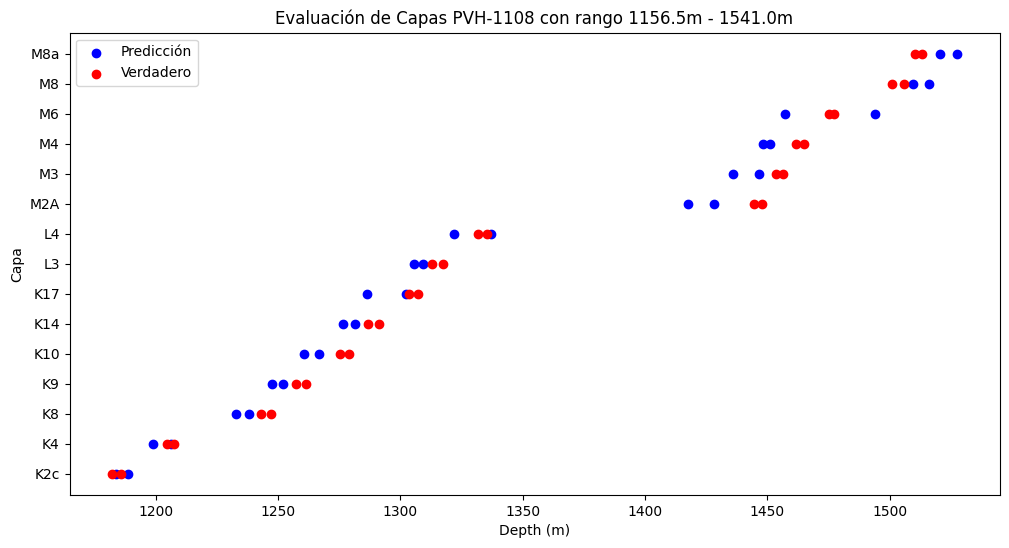

(10.87612000000006, 150.55560429333482)

In [16]:
start_node = "PVH-1007"
bound1 = optimal_window[2]
bound2 = optimal_window[3]
w = [bound1, bound2, bound1, bound2]

new_node = "PVH-1108"
calc_tops(G, start_node, new_node, window=w)
windows_test(G, start_node, new_node, w, show_plots=True)

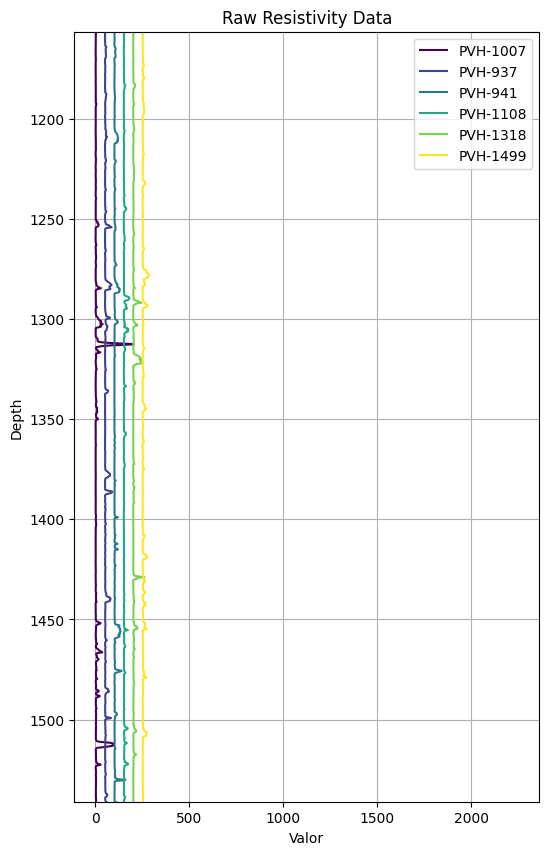

In [22]:
raw_data(G, G.nodes, r=[bound1, bound2])